# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vega import Vega
import json
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

from utils import fill_spec_with_data

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 1min 19s, sys: 9.96 s, total: 1min 29s
Wall time: 1min 31s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 50.4 s, sys: 1.64 s, total: 52 s
Wall time: 52.1 s


In [6]:
%%time
path = os.path.join('download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariates.columns if 'acronym_' in col]
selected_cols.append('n_mutations_log1p')
covariates = covariates[selected_cols]

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 66 ms


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [10]:
X = pd.concat([covariates, expression], axis=1)
print('Gene expression matrix shape: {0[0]}, {0[1]}'.format(expression.shape))
print('Covariates matrix shape: {0[0]}, {0[1]}'.format(covariates.shape))

# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Select the feature set for the different models
N_COVARIATES = covariates.shape[1]
def select_feature_set_columns(X, feature_set):
    if feature_set=='expressions': return X[:, N_COVARIATES:]
    return  X[:, :N_COVARIATES]

Gene expression matrix shape: 7306, 20468
Covariates matrix shape: 7306, 33


## Define pipeline and Cross validation model fitting

In [11]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__loss': ['log'],
        'classify__penalty': ['elasticnet'],
        'classify__alpha': [10 ** x for x in range(-3, 1)],
        'classify__l1_ratio': [0, 0.2, 0.8, 1],
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__loss': ['log'],
        'classify__penalty': ['elasticnet'],
        'classify__alpha': [10 ** x for x in range(-3, 1)],
        'classify__l1_ratio': [0, 0.2, 0.8, 1],
    },
    'covariates': {
        'classify__loss': ['log'],
        'classify__penalty': ['elasticnet'],
        'classify__alpha': [10 ** x for x in range(-3, 1)],
        'classify__l1_ratio': [0, 0.2, 0.8, 1],
    }
}

# Feature selection
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
    ])
}

models = ['full', 'expressions', 'covariates']

cv_pipelines = {mod: GridSearchCV(estimator=pipeline, 
                             param_grid=param_grids[mod], 
                             n_jobs=1, 
                             scoring='roc_auc') 
                for mod, pipeline in pipeline_definitions.items()}

In [12]:
%%time
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    pipeline.fit(X=X_train, y=y_train)

Fitting CV for model: full
Fitting CV for model: expressions
Fitting CV for model: covariates
CPU times: user 1h 15min 8s, sys: 12min 19s, total: 1h 27min 27s
Wall time: 31min


In [13]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('{0}: {1:.3%}'.format(model, pipeline.best_score_))

    print(pipeline.best_params_)

full: 91.436%
{'classify__alpha': 1, 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'features__expressions__pca__n_components': 100, 'classify__loss': 'log'}
expressions: 91.317%
{'classify__alpha': 1, 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'features__expressions__pca__n_components': 100, 'classify__loss': 'log'}
covariates: 84.259%
{'classify__alpha': 0.1, 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'classify__loss': 'log'}


## Visualize hyperparameters performance

In [14]:
cv_results_df_dict = {model: 
    pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params']),
    ], axis='columns') for model, pipeline in cv_pipelines.items()}

model = 'full'

cv_results_df_dict[model].head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_features__expressions__pca__n_components,params,...,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,features__expressions__pca__n_components
0,7.895540,0.594393,0.831632,0.842533,0.001,0,log,elasticnet,50,"{'classify__alpha': 0.001, 'classify__penalty'...",...,0.835554,0.988938,0.003305,0.011031,0.006692,0.001,0.0,log,elasticnet,50
1,8.340532,0.633971,0.875147,0.885227,0.001,0,log,elasticnet,100,"{'classify__alpha': 0.001, 'classify__penalty'...",...,0.876457,0.007593,0.004140,0.010407,0.017164,0.001,0.0,log,elasticnet,100


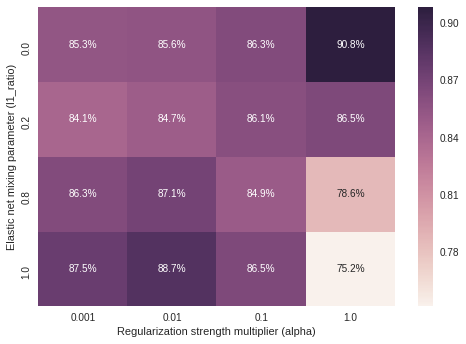

In [15]:
# Cross-validated performance heatmap
model = 'full'

cv_score_mat = pd.pivot_table(cv_results_df_dict[model],
                              values='mean_test_score', 
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [16]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

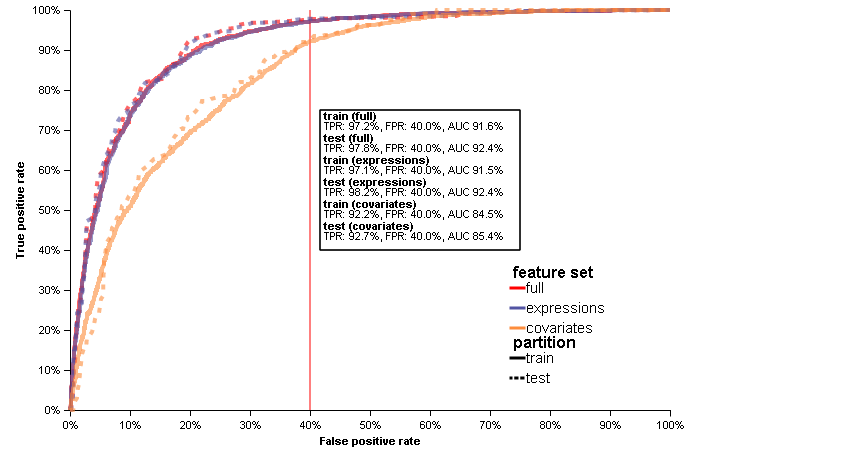

In [17]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

Vega(final_spec)

## What are the classifier coefficients?

In [18]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

In [19]:
def get_coefficients(classifier, feature_set):  
    coefs = classifier.coef_[0]   
    
    if feature_set=='expressions':
        features = ['PCA_%d' %cf for cf in range(len(coefs))]
    elif feature_set=='covariates': 
        features = covariates.columns
    else:        
        features = ['PCA_%d' %cf for cf in range(len(coefs) - len(covariates.columns))]
        features.extend(covariates.columns)
     
    coef_df = pd.DataFrame({'feature': features, 'weight': coefs})  
        
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    return coef_df
            
coef_df_dict = {
    model: get_coefficients(classifier, model)
    for model, classifier in final_classifiers.items()
}

In [20]:
model = 'full'

print('{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df_dict[model].weight == 0).mean(),
    (coef_df_dict[model].weight < 0).sum(),
    (coef_df_dict[model].weight > 0).sum()
))
coef_df_dict[model].head(10)

0.0% zero coefficients; 67 negative and 66 positive coefficients


,feature,weight,abs
8,PCA_8,-0.051846,0.051846
29,PCA_29,-0.050691,0.050691
22,PCA_22,-0.049605,0.049605
89,PCA_89,-0.047646,0.047646
37,PCA_37,0.045950,0.045950
34,PCA_34,-0.043017,0.043017
39,PCA_39,-0.042723,0.042723
2,PCA_2,-0.041899,0.041899
61,PCA_61,-0.041077,0.041077
87,PCA_87,-0.039667,0.039667


## Investigate the predictions

In [21]:
model = 'full'

predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', final_pipelines[model].decision_function(X)),
    ('probability', final_pipelines[model].predict_proba(X)[:, 1])
])

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [22]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,6.708712,0.998781,99.9%
TCGA-22-4591-01,TCGA-22-4591-01,0,0,5.727760,0.996756,99.7%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,5.182445,0.994417,99.4%
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,5.126745,0.994099,99.4%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,4.712347,0.991096,99.1%
TCGA-21-1081-01,TCGA-21-1081-01,0,0,4.599762,0.990046,99.0%
TCGA-BR-4369-01,TCGA-BR-4369-01,0,0,4.483290,0.988830,98.9%
TCGA-HF-7136-01,TCGA-HF-7136-01,0,0,4.176801,0.984884,98.5%
TCGA-09-2051-01,TCGA-09-2051-01,0,0,4.142432,0.984364,98.4%


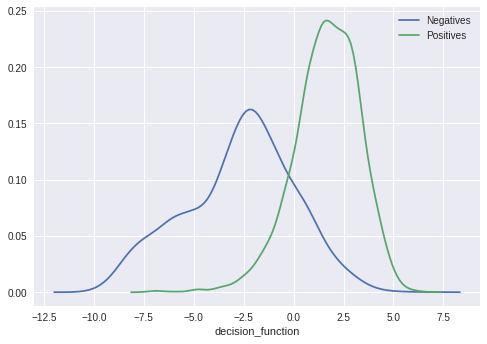

In [23]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

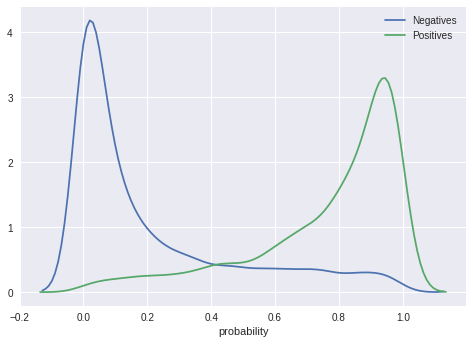

In [24]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')